# <div style="text-align:center; color:rgba(37, 40, 80);">11752 Machine Learning</div>
# <div style="text-align:center; color:rgba(37, 40, 80);">Master in Intelligent Systems</div>
# <div style="text-align:center; color:rgba(37, 40, 80);">Universitat de les Illes Balears</div>

### <div style="text-align:center; color:white;"> Handout #3: **Instance-based learning**</div>

#### **Integrants:** Jason Adel Noboa Rivera, Pedro Marti Pico
#### **Group:** 07





In [45]:
import numpy as np
import cvxpy as cp
from sklearn import svm

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import copy

group = '07' 

In [6]:
def build_H(X, y): #Function to calculate the H matrix 
    H = []
    for x1, y1 in zip(X,y):
        rows = []
        for x2, y2 in zip(X,y):
            value = (y1 * y2 * np.dot(x1, x2)).item()
            rows.append(value)
        H.append(rows)
    return H

def calculate_w(X,y,lm): #Function to calculate w from landa's values
    index = [i for i, lamb in enumerate(lm) if lamb[0] > 1e-6] 
    w = [0,0]
    for i in index:
        w += np.multiply(lm[i]*y[i],X[i])
    return w

def calculate_w0(X,y,w,lm): #Function to calculate w0 from landa's values
    index = [i for i, lamb in enumerate(lm) if lamb[0] > 1e-6]
    w0 = [0]
    for i in index:
        w0 += y[i] - w @ X[i].T #Formula is yi - w.Txi but we did in this way beacuse the disposition of the samples
    return w0/len(index)
    
def plot_class(c, X, y): #Function to plot class
    m1 = ['k', 'w']
    m2 = ['x', 'x']
    i = np.where(y == c)[0]
    plt.scatter(X[i, 0], X[i, 1], c=m1[c], marker=m2[c], label=f'w{c+1}')

def predictQPS(w, w0, x): #Function to predict the class with QPS
    value = w[0]*x[0] + w[1]*x[1] + w0[0] 
    if value < 0:
        value = [-1]
    else:
        value = [1]
        
    return value
    

##### T1. **Given dataset dsgg1.txt:**

a)	Solve for the SVM analytically using the Karush-Kuhn-Tucker conditions and the Wolfe dual representation making use of the quadratic programming solver and:

•	find and report the support vectors (NOTE: due to round-off errors, it is likely none of the $λ_i$ are exactly 0, but close, e.g. $10^{-6}$), and

•	calculate and report the resulting decision function $g(x)= w^T x+w_0.$

In [7]:
'''
1. commented source code
2. support vectors
3. decision function 
'''
#Import data
task = 1
data = np.loadtxt('ds'+group+str(task)+'.txt')
X = data[:,0:2]
oy = data[:,2:3] #CLass labels are 1 for w1 and 0 for w2

y = copy.deepcopy(oy)

for i in y:
    if i[0] == 0:
        i[0] = -1 #Change -1 instead 0 to execute the solver otherwise solver didn't work

#Code from slides
N = X.shape[0]
P = build_H(X,y)
G = -np.identity(N)
h = np.zeros((N,1))
A = y.reshape((1,N))
b = 0.0
z = cp.Variable((N,1))
P = P + (1e-8) * np.identity(N) # for numerical stability
prob = cp.Problem(cp.Minimize(0.5*cp.quad_form(z,P) - cp.sum(z)), 
                  [G @ z <= h, A @ z == b])
prob.solve(solver = cp.ECOS)
#print(prob.status)
lm = z.value  #This are landas

'''Support Vectors'''
index = [i for i, lamb in enumerate(lm) if lamb[0] > 1e-6] #Index of values different of 0
sv_sqp = X[index] #Obtain the support vectors
print(f"Support Vectors:\n {sv_sqp}")

'''Decision function'''
#Calculate w and w0 from landa's values
w_sqp = calculate_w(X,y,lm)
w0_sqp = calculate_w0(X,y,w_sqp,lm)

#print(f"w = {(w.round(5))}")
#print(f"w0 = {(w0.round(5))}")
print(f'\ng(x) = {w_sqp[0].round(5)}x1 + {w_sqp[1].round(5)}x2 + {w0_sqp[0].round(5)}')


Support Vectors:
 [[-0.82782933 -0.56098003]
 [-3.89957879  2.18935727]
 [ 0.2668493   1.38880936]]

g(x) = 0.61119x1 + 0.68261x2 + -0.11111


b)	Generate the following plots:

•	a first plot with the training samples, highlighting the support vectors and plotting the 2D decision curve

•	a second plot with the classification map, i.e. evaluate the decision function for a 'regular' subset (grid) of points of the feature space
Use different markers and/or colours for each class.


In [8]:
#Plot Functions
def plot_data(X,y):
    y = np.squeeze(y)

    '''Plot the samples'''
    X1 = X[y == 1.0]  #Points of class w1
    X2 = X[y == -1.0]  #Points of class w2

    plt.scatter(X1[:, 0], X1[:, 1], color='red', marker='x', label='W1')  #Plot points of class w1
    plt.scatter(X2[:, 0], X2[:, 1], color='green', marker='x', label='W2')  #Plot points of class w2

    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    plt.show()
    
def plot_decision_func(X, y, sv, w, w0, type:str):

    '''Add the circles in supported vector machines'''
    for loc in sv: #Locate the support vectors stored in sv
        px, py = loc
        circle = Circle((px,py), 0.2, fill=False)
        plt.gca().add_patch(circle)

    # Set the limits of the axes for better visualization
    plt.xlim([-6, 6])
    plt.ylim([-6, 6])

    '''Add the decision curve'''
    #Create x values
    x_values = np.linspace(-10, 10, 10)

    # calculate corresponding y values with decision function
    y_values = (-w[0] / w[1]) * x_values - w0[0] / w[1]

    # add the decission line to the plot
    plt.plot(x_values, y_values)

    '''Add the segmented lines'''
    #Calculate the distance of the segmented line: 1/||w||
    d = 1/np.linalg.norm(w) 

    #Calculate y values for the segmented lines
    y_values_segmented_line1 = y_values + d / np.sqrt(w[0]**2 + w[1]**2)
    y_values_segmented_line2 = y_values - d / np.sqrt(w[0]**2 + w[1]**2)

    #Add the segmented lines to the plot
    plt.plot(x_values, y_values_segmented_line1, '--', color = 'grey')
    plt.plot(x_values, y_values_segmented_line2, '--', color = 'grey')

    if type == 'SQP':
        plt.title(f'Quadratic Programming Solver\ng(x) = {w[0].round(4)}x1 + {w[1].round(4)}x2 + {w0[0].round(4)}', fontsize = 6 )
    elif type == 'SVC':
        plt.title(f'SVC Object\ng(x) = {w[0].round(4)}x1 + {w[1].round(4)}x2 + {w0[0].round(4)}', fontsize = 6 )

    plot_data(X, y)
    #plt.legend()
    #plt.show()

def plot_classification_map(X, w, w0, type, model=None):
    '''Classification map'''
    #Code used from teacher in previous handout
    x1lim = [X[:, 0].min(), X[:, 0].max()]
    x2lim = [X[:, 1].min(), X[:, 1].max()]

    npts = 100
    x1s = np.linspace(x1lim[0], x1lim[1], npts)
    x2s = np.linspace(x2lim[0], x2lim[1], npts)

    if type == 'SVC':
        model = model

    m = np.zeros((npts, npts))
    for k1, x1 in enumerate(x1s):
        for k2, x2 in enumerate(x2s):
            x = np.array([x1, x2])
            if type == 'SVC':
                prediction = model.predict([x]) # For fix the deprecation error
            else:
                prediction = predictQPS(w,w0,x) #Predict the model with our function
            m[k1, k2] = prediction[0]

    plt.figure()
    plt.imshow(m.T, cmap='RdYlGn', origin='lower', extent=(x1lim[0]-1, x1lim[1]+1, x2lim[0]-1, x2lim[1]+1))
    for c in range(2):  # Assuming binary classification. Change if more classes.
        plot_class(c, X, oy)
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    plt.show()

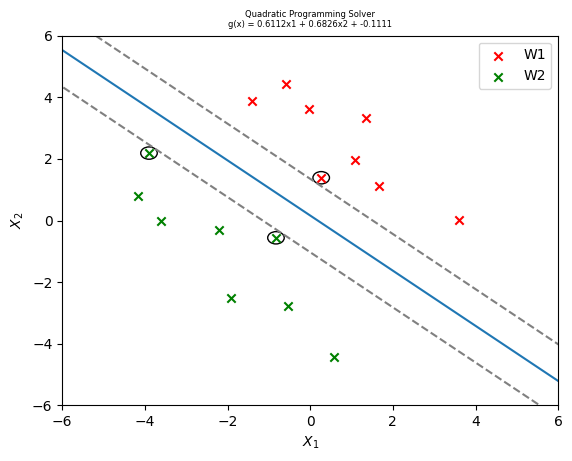

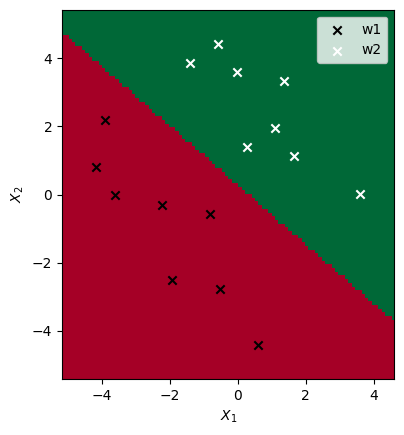

In [9]:
'''
1. commented source code
2. plot with samples and contour corresponding to the decision function
3. classification map
'''
plot_decision_func(X,y,sv_sqp,w_sqp,w0_sqp,'SQP')
plot_classification_map(X,w_sqp,w0_sqp,'SQP')

c)	Compare the results obtained with the ones resulting from the scikit-learn SVC object: i.e. report the support vectors returned by SVC and the corresponding decision function.

Support Vectors:
 [[-0.82782933 -0.56098003]
 [-3.89957879  2.18935727]
 [ 0.2668493   1.38880936]]

g(x) = 0.61098x1 + 0.68238x2 + -0.11119


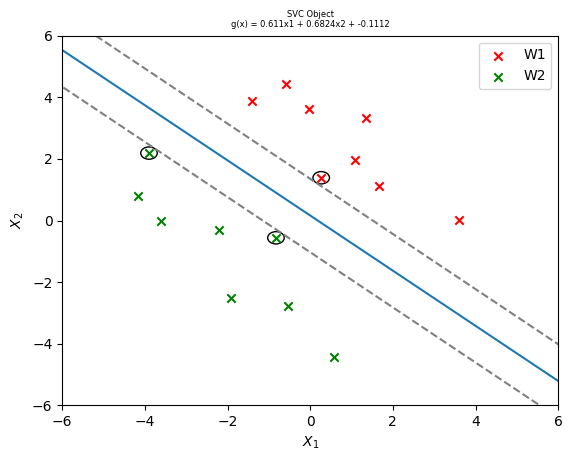

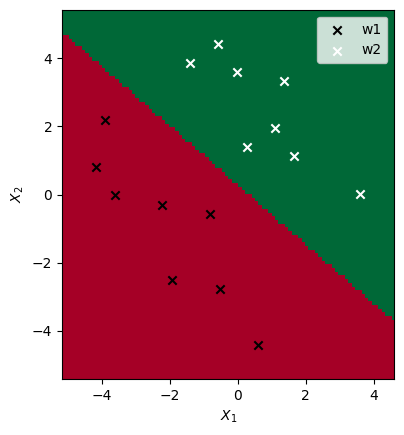

                                 MODEL COMPARATION                                
----------------------------------------------------------------------------------
                SQP Model               |                SVC Model                
                                 Support Vectors                                  
       [-0.82782933 -0.56098003]        |          [-0.82782933 -0.56098003]         
       [-3.89957879  2.18935727]        |          [-3.89957879  2.18935727]         
        [0.2668493  1.38880936]         |           [0.2668493  1.38880936]      
                               Decision function                 
g(x) = 0.61119x1 + 0.68261x2 + -0.11111 | g(x) = 0.61098x1 + 0.68238x2 + -0.11119


In [10]:
'''
1. commented source code
2. support vectors
3. decision function
4. plot with samples and contour corresponding to the decision function
5. classification map
'''
y = np.squeeze(y)

clf = svm.SVC(C = 1e16, kernel = 'linear')
clf.fit(X, y)

sv = clf.support_vectors_
w = clf.coef_.flatten()
w0 = clf.intercept_
lm = clf.dual_coef_.flatten()

print(f"Support Vectors:\n {sv}")
print(f'\ng(x) = {w[0].round(5)}x1 + {w[1].round(5)}x2 + {w0[0].round(5)}')

plot_decision_func(X,y,sv,w,w0,'SVC')
plot_classification_map(X,w,w0,'SVC',clf)

#Comparation between both models
print("                                 MODEL COMPARATION                                ")
print("----------------------------------------------------------------------------------")
print("                SQP Model               |                SVC Model                ")
print("                                 Support Vectors                                  ")
print(f"       {sv_sqp[0]}        |          {sv[0]}         ")
print(f"       {sv_sqp[1]}        |          {sv[1]}         ")
print(f"        {sv_sqp[2]}         |           {sv[2]}      ")
print("                               Decision function                 ")
print(f'g(x) = {w_sqp[0].round(5)}x1 + {w_sqp[1].round(5)}x2 + {w0_sqp[0].round(5)} | g(x) = {w[0].round(5)}x1 + {w[1].round(5)}x2 + {w0[0].round(5)}')



##### T2. **Given dataset dsgg2.txt:**

a)Mapping the training samples $x=(x_1,x_2)$ onto an alternative 2-dimensional space using $Φ(x)=(x_1 x_2,{x_1}^2+{x_2}^2)$, solve for the SVM analytically using the quadratic programming solver and

  •	find and report the support vectors in the original space, and

  •	calculate and report the resulting decision function both in the transformed space          $g_1(x')=w^T x'+w_0 [x'=Φ(x)]$ and in the original space $g_2 (x)=w^T Φ(x)+w_0$.

In [22]:
def phi(x):
    return np.array([x[0] * x[1], x[0]**2 + x[1]**2])

# Decision function in the original space
def decision_function_original(X):
    return np.dot(np.array([phi(x) for x in X]), w) + b

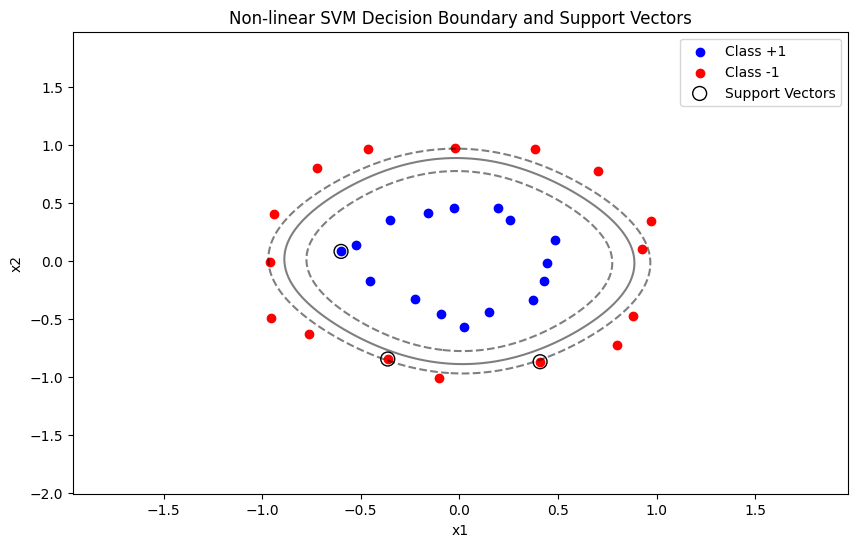

In [28]:
'''
1. commented source code
2. support vectors
3. decision functions
'''
#Import data
task = 2
data = np.loadtxt('ds'+group+str(task)+'.txt')
X = data[:,0:2]
y = data[:,2:3].flatten()

# Convert the labels to -1 y +1
y = np.where(y == 0, -1, 1)

# Transform the features with $Φ(x)=(x_1 x_2,{x_1}^2+{x_2}^2)$
X_transformed = np.array([phi(x) for x in X])

#print(X_transformed.shape)
# Quadratic Programming for SVM
n_samples, n_features = X_transformed.shape # Extract num samples and features from transformed data
alpha = cp.Variable(n_samples) # Alphas to identify support vectors

# Calculate the Gram matrix for the transformed features
"""
Capturamos la similitud entre cada par de puntos en el espacio de características
"""
K = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        """
        K[i, j] contiene el resultado del producto punto entre el vector de 
        características transformadas de la muestra i y el de la muestra j
        """
        K[i, j] = np.dot(X_transformed[i], X_transformed[j])

# Formulate the quadratic programming problem
objective = cp.Minimize(0.5 * cp.quad_form(alpha, K * np.outer(y, y)) - cp.sum(alpha))
constraints = [alpha >= 0, cp.sum(cp.multiply(alpha, y)) == 0]
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Extract support vectors
sv = alpha.value > 1e-5
support_vectors = X[sv]
support_vector_labels = y[sv]
alpha_sv = alpha.value[sv].flatten()

# Compute the weight vector and bias
w = np.sum((alpha_sv * support_vector_labels)[:, np.newaxis] * X_transformed[sv], axis=0)

# Compute the bias term b
# Calculate decision values for support vectors and average them
decision_values = np.dot(X_transformed[sv], w)
b = np.mean(support_vector_labels - decision_values)

# Plotting
plt.figure(figsize=(10, 6))

# Plot data points
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class +1')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class -1')

# Create grid to plot decision boundaries
grid_x1, grid_x2 = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 200),
                               np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 200))
grid = np.array([phi([x1, x2]) for x1, x2 in zip(np.ravel(grid_x1), np.ravel(grid_x2))])

# Plot decision boundary
# Evaluate the decision function for the grid
Z = decision_function_original(grid).reshape(grid_x1.shape)

#Plot decision boundary and margins
plt.contour(grid_x1, grid_x2, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors='k')

# Highlight the support vectors
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, 
            facecolors='none', edgecolors='black', label='Support Vectors')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Non-linear SVM Decision Boundary and Support Vectors')
plt.legend()
plt.show()

In [13]:
#This is a non-linear SVM problem

b)	Generate the following plots:

•	a first plot with the training samples in the transformed space, highlighting the support vectors and plotting the 2D decision curve;

•	a second plot with the training samples in the original space, highlighting the support vectors and plotting the 2D decision curve; and

•	a third plot with the classification map in the original space, i.e. evaluate the decision function for a ’regular’ subset (grid) of points.


In [14]:
'''
Use different markers and/or colours for each class.
1. commented source code
2. plots with samples and contour corresponding to the decision function
3. classification map
'''

'\nUse different markers and/or colours for each class.\n1. commented source code\n2. plots with samples and contour corresponding to the decision function\n3. classification map\n'

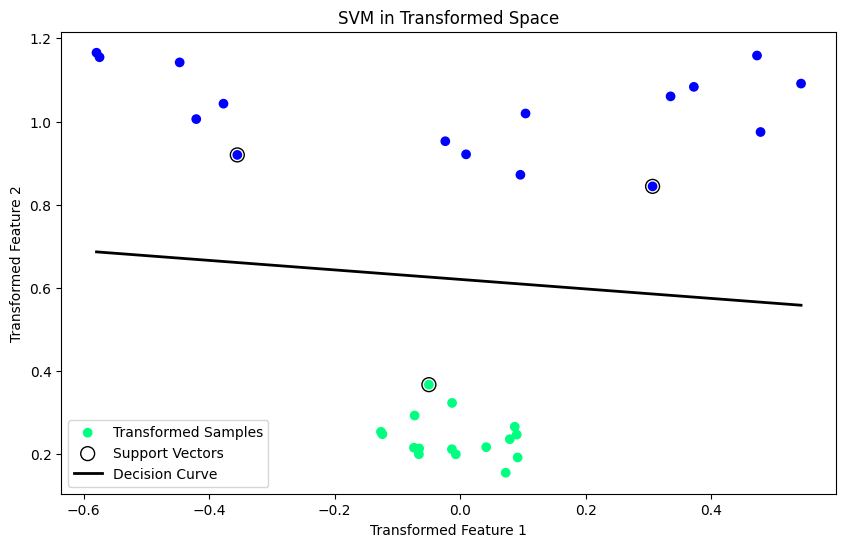

In [42]:
# Plotting in the Transformed Space
plt.figure(figsize=(10, 6))

# Plot transformed samples
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap=plt.cm.winter, label='Transformed Samples')

# Highlight the support vectors in the transformed space
plt.scatter(X_transformed[sv, 0], X_transformed[sv, 1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')

# Plot the decision boundary
decision_curve = np.linspace(X_transformed[:, 0].min(), X_transformed[:, 0].max(), 100)
decision_boundary = (-w[0] * decision_curve - b) / w[1]
plt.plot(decision_curve, decision_boundary, 'k-', linewidth=2, label='Decision Curve')

plt.xlabel('Transformed Feature 1')
plt.ylabel('Transformed Feature 2')
plt.title('SVM in Transformed Space')
plt.legend()
plt.show()


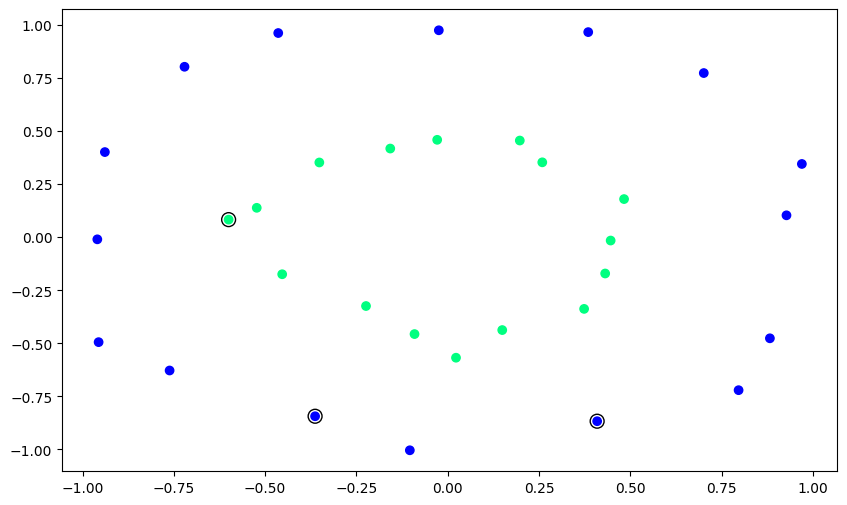

In [35]:
# Plotting in the Original Space
plt.figure(figsize=(10, 6))

# Plot original samples
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.winter, label='Original Samples')

# Highlight the support vectors in the original space
plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
s=100, facecolors='none', edgecolors='k', label='Support Vectors')


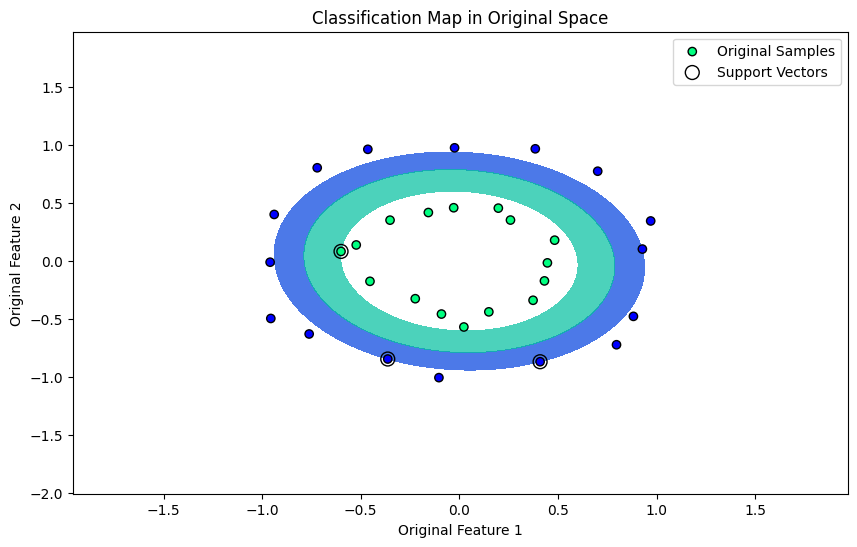

In [44]:
# Plotting the Classification Map in the Original Space
plt.figure(figsize=(10, 6))

# Create a grid of points to evaluate the decision function
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Calculate the decision values for all points in the grid
# Apply the transformation to each point in the grid and calculate the decision function value
Z = np.array([phi([x1, x2]) for x1, x2 in zip(np.ravel(xx), np.ravel(yy))])
decision_values = np.dot(Z, w) + b  # w y b son tus parámetros del modelo SVM
Z = decision_values.reshape(xx.shape)

# Plot the classification map using contourf
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.7, cmap=plt.cm.winter, linestyles=['--', '-', '--'])

# Plot the original training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.winter, edgecolors='k', label='Original Samples')

# Highlight the support vectors
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')

plt.xlabel('Original Feature 1')
plt.ylabel('Original Feature 2')
plt.title('Classification Map in Original Space')
plt.legend()
plt.show()



c)	Compare the results obtained with the ones resulting from the scikit-learn SVC object: i.e. report the support vectors returned by SVC and the corresponding decision function.

In [15]:
'''
1. commented source code
2. support vectors
3. decision function
4. plot with samples and contour corresponding to the decision function
5. classification map
'''

'\n1. commented source code\n2. support vectors\n3. decision function\n4. plot with samples and contour corresponding to the decision function\n5. classification map\n'

In [65]:
# Transform the features
X_transformed = np.array([phi(x) for x in X])

# Precompute the Gram matrix for the SVC
G = np.dot(X_transformed, X_transformed.T)

# Fit the SVC model
svc = SVC(kernel='precomputed', C=1e16)
svc.fit(G, y)

# Extract support vectors for scikit-learn SVC
svc_support_vectors = X[svc.support_]

# Calculate the decision function for Custom SVM
# Ensure this variable is calculated from your custom SVM model
custom_decision_values = decision_function_original(X)
svc_decision_values = svc.decision_function(G)

print("Support Vectors from scikit-learn SVC:\n", svc_support_vectors)

# Extract support vectors for Custom SVM
# Ensure this variable is correctly obtained from your custom SVM model
print("Support Vectors from Custom SVM:", support_vectors)

# Print decision function values for comparison
print("Decision Function Values from Custom SVM:", custom_decision_values)
print("Decision Function Values from scikit-learn SVC:", svc_decision_values)


Support Vectors from scikit-learn SVC:
 [[-0.36316507 -0.84385895]
 [ 0.4093559  -0.86721216]
 [-0.60006218  0.08304767]]
Support Vectors from Custom SVM: [[-0.36316507 -0.84385895]
 [-0.60006218  0.08304767]
 [ 0.4093559  -0.86721216]]
Decision Function Values from Custom SVM: [ 1.40202449  1.15341314 -2.05941578  1.33054082  1.59870886 -1.0144303
 -1.30403384 -1.84890336  1.44940441 -1.58102422  1.59659787  1.62805623
  1.54045382 -1.16634983 -2.28917391  1.29664857 -1.         -1.46638881
 -1.81910442  1.4713722   1.58328661 -1.8107506   1.76411553  1.49292705
 -1.58771133 -1.85044705 -1.27340467 -1.95362061  1.65361233  1.61390969
  1.         -1.        ]
Decision Function Values from scikit-learn SVC: [ 1.40267131  1.15383944 -2.05901401  1.33116391  1.59917541 -1.01441915
 -1.30487312 -1.84875659  1.4500474  -1.58059146  1.59705138  1.62861813
  1.5410648  -1.1665088  -2.28893849  1.2970238  -0.9996698  -1.46720641
 -1.82012059  1.47171372  1.58382715 -1.81195561  1.76483268  1.

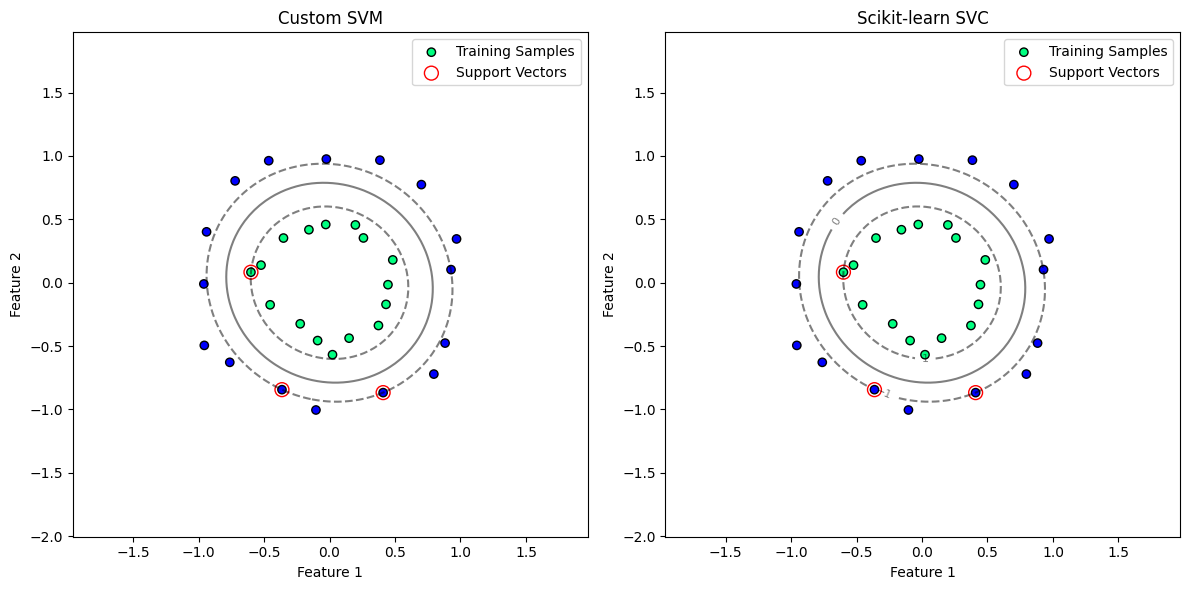

In [67]:
# PlOT CUSTOM
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.winter, edgecolors='k', label='Training Samples')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='r', label='Support Vectors')

# Add decision boundary plot for custom SVM
# Grid for plotting
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Apply custom SVM decision function
Z = np.array([decision_function_original(np.array([[x, y]])) for x, y in zip(np.ravel(xx), np.ravel(yy))])
Z = np.reshape(Z, xx.shape)

# Plot decision boundary for custom SVM
plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors='k')


plt.title('Custom SVM')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# PLOT SCIKIT-LEARN SVC
plt.subplot(1, 2, 2)

# Scatter plot for the data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.winter, edgecolors='k', label='Training Samples')
plt.scatter(svc_support_vectors[:, 0], svc_support_vectors[:, 1], s=100, facecolors='none', edgecolors='r', label='Support Vectors')

# Compute the Gram matrix for the grid points
X_grid = np.array([phi([x, y]) for x, y in zip(np.ravel(xx), np.ravel(yy))])
G_grid = np.dot(X_grid, X_transformed.T)

# Evaluate the decision function using the Gram matrix of grid points
Z = svc.decision_function(G_grid)
Z = Z.reshape(xx.shape)

# Plot decision boundary for scikit-learn SVC
contour = plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors='k')
plt.clabel(contour, inline=True, fontsize=8)

plt.title('Scikit-learn SVC')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()

plt.show()


d) Also by means of the scikit-learn SVC object, repeat point c) for the 'rbf' kernel. Additionally, draw the corresponding RBF network (slide 42 of the SVM lecture notes, replacing $K(x_i,x)$, $λ_i$ and $y_i$ by your values).

In [16]:
'''
1. commented source code
2. support vectors
3. plot with samples and contour corresponding to the decision function
4. classification map
5. RBF network
'''

'\n1. commented source code\n2. support vectors\n3. plot with samples and contour corresponding to the decision function\n4. classification map\n5. RBF network\n'

Support Vectors from scikit-learn SVC with RBF kernel:
 [[ 0.70145577  0.77405558]
 [ 0.92795713  0.10339909]
 [-0.95964905 -0.00979587]
 [-0.36316507 -0.84385895]
 [-0.93896523  0.40153646]
 [-0.72082694  0.80364849]
 [-0.02430107  0.97567027]
 [ 0.4093559  -0.86721216]
 [ 0.02276649 -0.56790611]
 [ 0.48308517  0.17996887]
 [-0.60006218  0.08304767]]


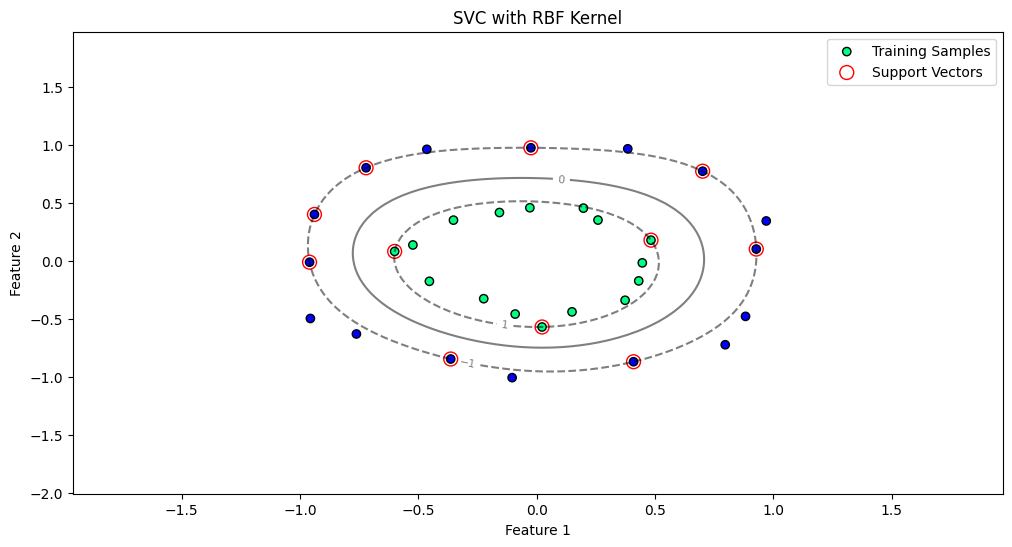

In [69]:
# Fit the SVC model with RBF kernel
svc_rbf = SVC(kernel='rbf', C=1e16)
svc_rbf.fit(X, y)

# Extract support vectors
svc_rbf_support_vectors = svc_rbf.support_vectors_
print("Support Vectors from scikit-learn SVC with RBF kernel:\n", svc_rbf_support_vectors)

# PLOTTING FOR THE RBF KERNEL
plt.figure(figsize=(12, 6))

# Plot for the SVC with RBF kernel
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.winter, edgecolors='k', label='Training Samples')
plt.scatter(svc_rbf_support_vectors[:, 0], svc_rbf_support_vectors[:, 1], s=100, facecolors='none', edgecolors='r', label='Support Vectors')

# Decision boundary and margin for SVC with RBF kernel
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

Z = svc_rbf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

contour = plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors='k')
plt.clabel(contour, inline=True, fontsize=8)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVC with RBF Kernel')
plt.legend()
plt.show()


##### T3. **T3.	Given dataset dsgg3tr.txt/dsgg3te.txt**, find a suitable k-Nearest Neighbour (k-NN) classifier to adequately address the involved task.

a) Define the design strategy: combinations of hyper-parameters considered (number of neighbours and distance function), tuning approach (folds and repetitions).

b)	Using the training dataset, find the best performing classifier according to the design strategy and employing the accuracy as performance metric for the cross-validation process.

In [17]:
'''
1. commented source code (for a & b above)
2. resulting configuration
'''

'\n1. commented source code (for a & b above)\n2. resulting configuration\n'

c)	Plot the training samples on top of the classification map, i.e. evaluate the decision function for a ’regular’ subset (grid) of points of the feature space (use different markers and/or colours for each class).

In [18]:
'''
1. commented source code
2. classification map with training samples plotted
'''

'\n1. commented source code\n2. classification map with training samples plotted\n'

d)	Report on the classifier performance using the test dataset:

•	measure the test accuracy, test precision, test recall and test f1-score, and

•	in a single figure, plot the test samples over the already calculated classification map (use different markers and/or colours for each class).


In [19]:
'''
1. commented source code
2. test accuracy, test precision, test recall and test f1-score
3. classification map with test samples plotted
'''

'\n1. commented source code\n2. test accuracy, test precision, test recall and test f1-score\n3. classification map with test samples plotted\n'

e)	Obtain an improved estimation of the accuracy, precision, recall and f1-score measures by means of repeated, n-fold cross-validation. To this end, put together the training and test datasets, so that the corresponding function can build the folds from all available data.

In [20]:
'''
1. commented source code
2. accuracy, precision, recall and f1-score
'''

'\n1. commented source code\n2. accuracy, precision, recall and f1-score\n'